# Autograd: Ship

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v3 as io
import autograd.numpy as anp
from autograd import grad
from PIL import Image
import math
from skimage.transform import resize
from skimage import color
from skimage.io import imsave
%matplotlib inline

In [2]:
# fftshift: shifting centre (jumble)
# ifftshift: inverses shifting centre (jumble)
# fft2: fourier transform 2D (makes it black)
# ifft2: inverse 2D discrete Fast fourier transform (brings back colour)

# fft2 on fft2: makes image upside down


In [2]:
def TV(a):
    ux, uy = anp.gradient(a)
    g = anp.sqrt(anp.abs(ux)**2 + anp.abs(uy)**2 + 1e-10)
    s = anp.sum(g[:])
    return s

def data_error(guess, blurred, h):
    G = anp.fft.fftshift(anp.fft.fft2(anp.fft.ifftshift(guess)))
    H = anp.fft.fftshift(anp.fft.fft2(anp.fft.ifftshift(h)))
    err = blurred - anp.real(anp.fft.fftshift(anp.fft.ifft2(anp.fft.ifftshift(G*H))))
    err2 = err**2
    l2err = anp.sum(err2[:])
    return l2err   



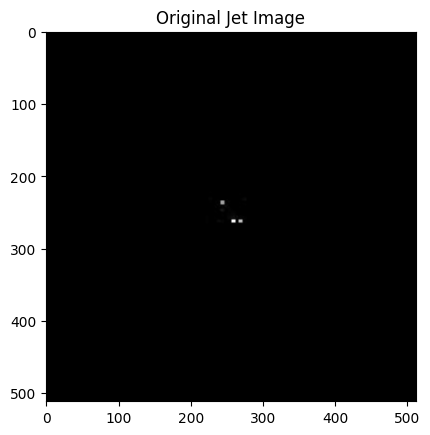

(512, 512)

In [3]:
# Read a test image

img = io.imread("D:/SEM 4/Project2/Images/signal_200/jet_image_jet_constituents_data_1.jpeg")
img=resize(color.rgb2gray(img),(512,512))
plt.figure(1)
plt.title("Original Jet Image")
plt.imshow(img, cmap='gray')
plt.show()
img.shape



In [4]:
# Define a blur function on the grid
x0 = np.linspace(-255.5, 255.5, 512, endpoint=True)
x, y = np.meshgrid(x0,x0)
 # Square window psf
h = np.sinc(x/5) * np.sinc(y/5)  # sinc blur function
# h = np.exp(-(x**2 + y**2)/10) 
# Gaussian psf extending everywhere
h[(np.abs(x)<5) * (np.abs(y)<5)] = 1 


h = h / np.sum(h[:])
# plt.figure(2)
# plt.imshow(np.real(h), cmap='gray')


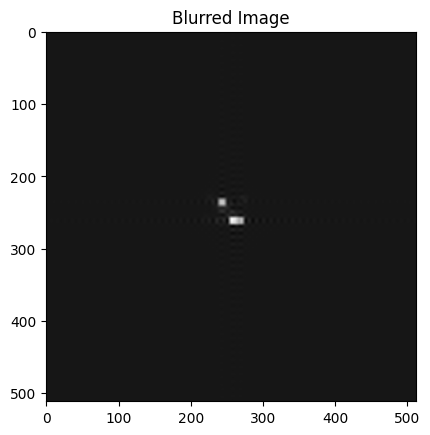

[[-1.49496859e-06 -1.83523012e-06 -1.24947689e-06 ...  1.77711164e-06
   7.06584880e-07 -4.36171413e-07]
 [ 3.35047441e-06  1.44313104e-06 -4.34616593e-08 ...  2.32385983e-06
   4.32408138e-06  4.38874282e-06]
 [ 6.92018446e-06  4.23100966e-06  1.47618745e-06 ...  2.02954114e-06
   6.20670048e-06  7.83677458e-06]
 ...
 [-6.26554079e-06 -3.70019164e-06 -8.17723637e-07 ... -1.83783880e-06
  -5.76705380e-06 -7.46232674e-06]
 [-7.42665469e-06 -5.01776022e-06 -1.76573462e-06 ... -8.32034320e-07
  -5.46097565e-06 -7.94716332e-06]
 [-5.61925922e-06 -4.37726562e-06 -1.75992351e-06 ...  5.15337241e-07
  -3.00146749e-06 -5.14064127e-06]]


In [5]:
# Blurred image

A = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))
H = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(h)))
b = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(A*H))))

# Add noise
noise = np.random.rand(512,512) * 0.001 * np.mean(b[:])
b = b + noise

plt.figure(3)
plt.title("Blurred Image")
plt.imshow(b, cmap='gray')
plt.show()
print(b)

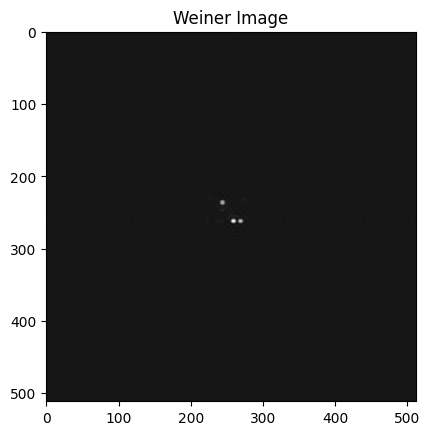

In [6]:
# Wiener filter recovery
NSR = 0.001
W = np.conj(H) / (np.abs(H)**2 + NSR)

# Deblur using Wiener filter
B = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(b)))
b1 = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(B*W))))
plt.figure(4)
plt.title("Weiner Image")
plt.imshow(np.real(b1), cmap='gray')
plt.show()

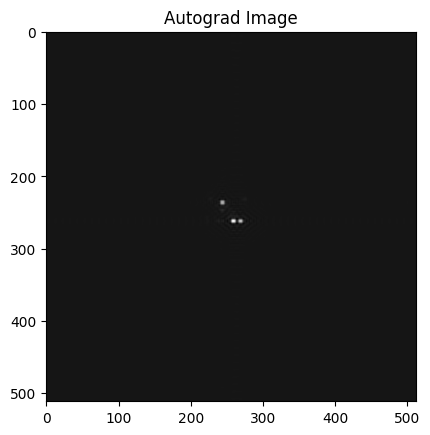

In [18]:
# Iterative TV based deconvolution ... starting with Winer filter solution as first guess

gerr = grad(data_error, 0)
gtv = grad(TV, 0)

alpha = 1
guess = b1
t = 0.1

for iter in np.arange(1,11,1):
    
    C1 = data_error(guess, b, h)
    dC1 = gerr(guess, b, h)
    C2 = TV(guess)
    dC2 = gtv(guess)
    C = C1 + alpha*C2
    dC = dC1 + alpha*dC2
    dC = dC / np.linalg.norm(dC)
    donet = 0
    
    while(not donet):
        guess_try = guess - t* np.linalg.norm(guess) * dC
        C1try = data_error(guess_try, b, h)
        C2try = TV(guess_try)
        Ctry = C1try + alpha*C2try
        
        if(Ctry < C):
            donet = 1
            guess = guess_try
        else:
            t = t/2
            
    if(t < 1e-6):
        break
    else:
        t = 0.1


plt.figure(5)
plt.title("Autograd Image")
plt.imshow(guess, cmap='gray')
plt.show()


In [19]:
from math import log10, sqrt 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr
value = PSNR(img, guess) 
# value_np = PSNR(img, guess_np)
print(value)

100.16531630872356


In [30]:
error1= (guess-b)**2
print("SSQ Error Autograd from blurred image: ", np.mean(error1))
error2= (guess-img)**2
print("SSQ Error Autograd from Original image: ", np.mean(error2))
error3= (guess-b1)**2
print("SSQ Error Autograd from Weiner image: ", np.mean(error3))

SSQ Error Autograd from blurred image:  7.402191402781852e-05
SSQ Error Autograd from Original image:  6.259621981964632e-06
SSQ Error Autograd from Weiner image:  1.0736899645401998e-08


# Numpy code: Ship

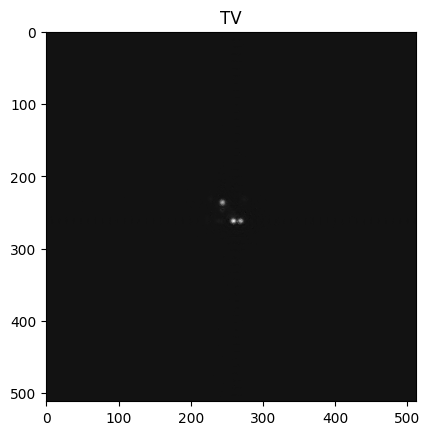

In [15]:
#Delta C
#Gin=guess
#Gout=blur
# plt.figure(1)
# plt.title("ORIGINAL")
# plt.imshow(img, cmap='gray')

# plt.figure(2)
# plt.title("NOISY")
# plt.imshow(b1, cmap='gray')


# plt.figure(3)
# plt.title('BLURRED')
# plt.imshow(b, cmap='gray')

Gin= np.array(b1)
Gout=np.array(b)

def TV_np(a):
    ux, uy = np.gradient(a)
    g = np.sqrt(np.abs(ux)**2 + np.abs(uy)**2 + 1e-10)
    s = np.sum(g[:])
    return s
def gradd(Gin, Gout, alpha):
    #First term
    term1=-2*(Gout-Gin)
    
    #Second term
    delGin= np.gradient(Gin)
    gx=delGin[1]
    gy=delGin[0]
    denom = np.sqrt(gx**2 + gy**2 + np.random.rand(512,512))
    
    term2= alpha*(np.gradient(np.divide(gx,denom))[1]+ np.gradient(np.divide(gy,denom),1)[0])
    delC= term1 - term2
    return delC
def Cmin(Gout,Gin,alpha):
    C_Gin= np.linalg.norm((Gout-Gin))**2 + alpha*TV_np(Gin)
    return C_Gin

t = 1000

alpha=10000000000000
Tvalpha=[]
alphar=[]
werr=[]
berr=[]
for i in range(12):
    if (i==1):
        break
    guess_np=b1
    for iter in np.arange(1,11,1):
        dC = gradd(guess_np, Gout, alpha)
        donet = 0
        C=Cmin(Gout,guess_np,alpha)
        while(not donet):
            guess_try = guess_np - t*dC
            Ctry=Cmin(Gout,guess_try,alpha)
           
            
            if(Ctry < C):
                donet = 1
                guess_np = guess_try
            else:
                t = t/2
                
        if(t < 1e-6):
            break
        else:
            t = 0.1 
    Tvalpha.append(TV(guess_np))
    alphar.append(alpha)
    berr.append(np.mean((guess_np-b)**2))
    werr.append(np.mean((guess_np-b1)**2))
    alpha=alpha*10

# plt.xscale('log')
# plt.plot(alphar,berr,label='error from blurred')
# plt.plot(alphar,werr,label='error from wiener')
# plt.xlabel("Alpha")
# plt.ylabel("Error")
# plt.legend()

plt.figure(4)
plt.title("TV")
plt.imshow(guess_np, cmap='gray') 
#Calculating TV:
# print("TV of original image: ", TV(img))
# print("TV of blurred image: ", TV(b))
# print("TV of Weiner filter image: ", TV(b1))
# print("TV of autograd method image: ", TV(guess))
# print("TV of our image: ", TV(guess_np))
# plt.figure(5)
# plt.bar(['original','blurred','Weiner', 'autograd','ours'],[TV(img),TV(b),TV(b1),TV(guess),TV(guess_np)])
# plt.ylabel("Total variation of ship image")




In [23]:
# #ERRORS WRT ORIGINAL IMAGE
# error1= (guess-b)**2
# print("SSQ Error Autograd from blurred image: ", np.mean(error1))
error2= (guess-img)**2
print("SSQ Error of Autograd image: ", np.mean(error2))

# #ERRORS WRT WEINER IMAGE
# error3= (guess-b1)**2
# print("SSQ Error Autograd from Weiner image: ", np.mean(error3))
error4=(guess_np-img)**2
print("SSQ Error of Numpy image: ", np.mean(error4))

error1=(b1 - img)**2
print("SSQ Error of Weiner image: ", np.mean(error1))

SSQ Error of Autograd image:  6.259630961461718e-06
SSQ Error of Numpy image:  2.569521726328883e-05
SSQ Error of Weiner image:  6.366440628713864e-06


In [17]:
from math import log10, sqrt 
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                   # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr
# value = PSNR(img, guess) 
value_np = PSNR(img, guess_np)
print(value_np)

94.03228066698497


In [22]:
def signaltonoiseScipy(a, axis=None, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

SNRscipy = 20*log10(abs(signaltonoiseScipy(guess_np)))

print("SNR by scipy: {} dB".format(SNRscipy))

SNR by scipy: -30.358463728211646 dB


In [20]:
from scipy import stats 
print(stats.signaltonoise(guess_np, axis = 0, ddof = 0))

AttributeError: module 'scipy.stats' has no attribute 'signaltonoise'

# Butterfly

TV of original image:  5549.958162084676
TV of blurred image:  90812.21435704395
TV of noisy image:  16183.667914666947
TV of our image:  78713.23585150916


Text(0, 0.5, 'Total variation of butterfly image')

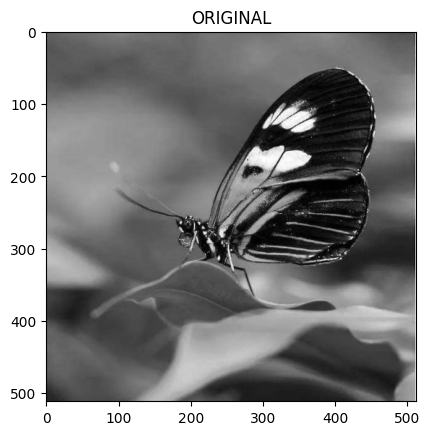

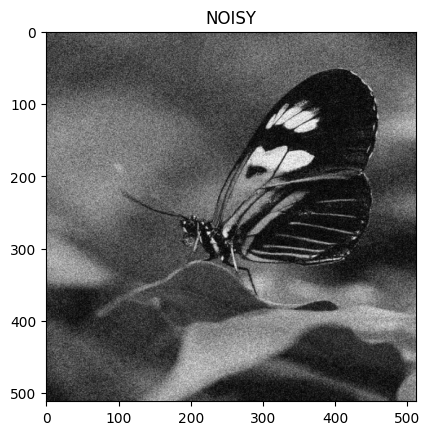

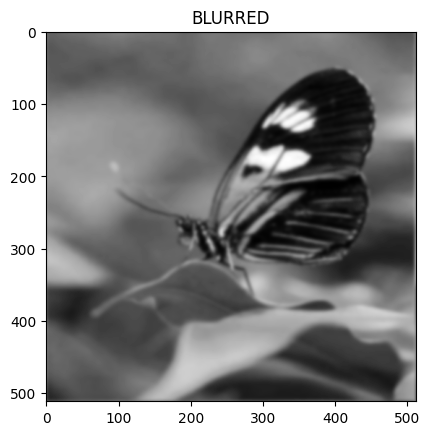

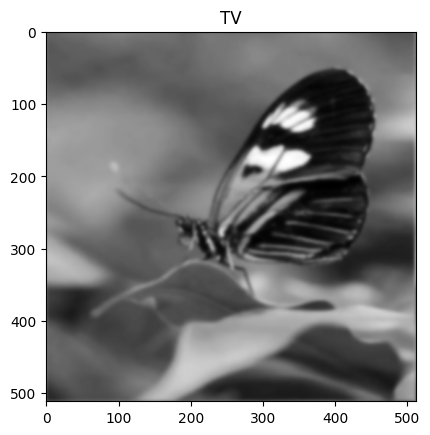

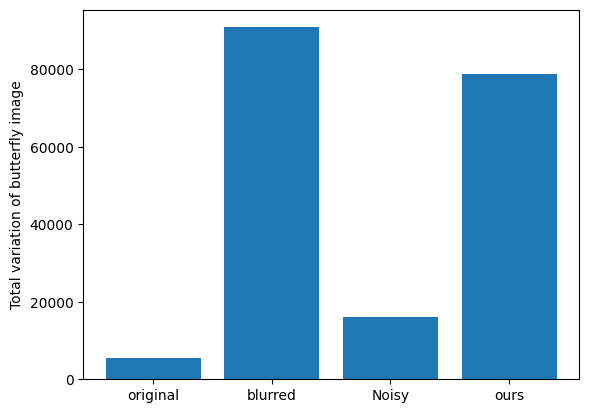

In [11]:
#Delta C
#Gin=guess
#Gout=blur
from skimage import color
from skimage.transform import resize
b1 = resize(color.rgb2gray(io.imread("D:/SEM 4/Project2/noisy2.jpg")),(512,512))
im = resize(color.rgb2gray(io.imread("D:/SEM 4/Project2/clear2.jpg")),(512,512))

plt.figure(1)
plt.title("ORIGINAL")
plt.imshow(im, cmap='gray')


# Blurred image

A = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im)))
h = np.exp(-(x**2 + y**2)/10)
H = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(h)))
b = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(A*H))))

plt.figure(2)
plt.title("NOISY")
plt.imshow(b1, cmap='gray')
# Add noise
noise = np.random.rand(512,512) * 0.001 * np.mean(b[:])
b = b + noise

plt.figure(3)
plt.title('BLURRED')
plt.imshow(b, cmap='gray')

Gin= np.array(b1)
Gout=np.array(b)

def TV_np(a):
    ux, uy = np.gradient(a)
    g = np.sqrt(np.abs(ux)**2 + np.abs(uy)**2 + 1e-10)
    s = np.sum(g[:])
    return s
def gradd(Gin, Gout, alpha):
    #First term
    term1=-2*(Gout-Gin)
    
    #Second term
    delGin= np.gradient(Gin)
    gx=delGin[1]
    gy=delGin[0]
    denom = np.sqrt(gx**2 + gy**2 + np.random.rand(512,512))
    
    term2= alpha*(np.gradient(np.divide(gx,denom))[1]+ np.gradient(np.divide(gy,denom),1)[0])
    delC= term1 - term2
    return delC
def Cmin(Gout,Gin,alpha):
    C_Gin= np.linalg.norm((Gout-Gin))**2 + alpha*TV_np(Gin)
    return C_Gin

t = 0.1

alpha=1
Tvalpha=[]
alphar=[]
werr=[]
berr=[]
for i in range(12):
    if (i==1):
        break
    guess_np=b1
    for iter in np.arange(1,11,1):
        dC = gradd(guess_np, Gout, alpha)
        donet = 0
        C=Cmin(Gout,guess_np,alpha)
        while(not donet):
            guess_try = guess_np - t*dC
            Ctry=Cmin(Gout,guess_try,alpha)
           
            
            if(Ctry < C):
                donet = 1
                guess_np = guess_try
            else:
                t = t/2
                
        if(t < 1e-6):
            break
        else:
            t = 0.1 
    Tvalpha.append(TV(guess_np))
    alphar.append(alpha)
    berr.append(np.mean((guess_np-b)**2))
    werr.append(np.mean((guess_np-b1)**2))
    alpha=alpha*10

# plt.xscale('log')
# plt.plot(alphar,berr,label='error from blurred')
# plt.plot(alphar,werr,label='error from wiener')
# plt.xlabel("Alpha")
# plt.ylabel("Error")
# plt.legend()

plt.figure(4)
plt.title("TV")
plt.imshow(guess_np, cmap='gray') 
# plt.imshow(guess_np, cmap='gray') 
print("TV of original image: ", TV(im))
print("TV of blurred image: ", TV(b))
print("TV of noisy image: ", TV(b1))
print("TV of our image: ", TV(guess_np))
plt.figure(5)
plt.bar(['original','blurred','Noisy', 'ours'],[TV(im),TV(b),TV(b1),TV(guess_np)])
plt.ylabel("Total variation of butterfly image")



# City

TV of original image:  8749.499245131332
TV of blurred image:  113606.15158713565
TV of noisy image:  21593.396035742702
TV of our image:  95950.05977516962


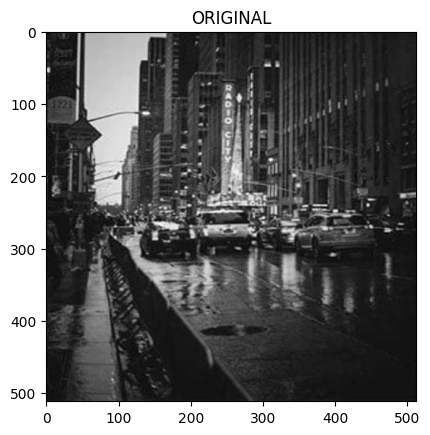

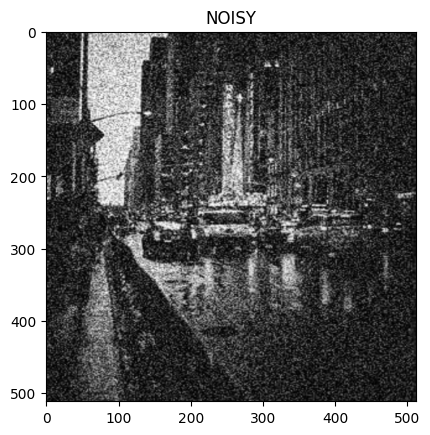

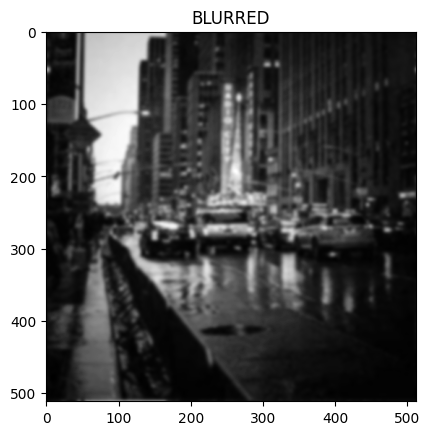

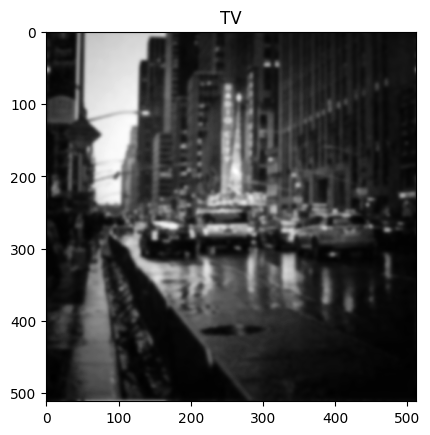

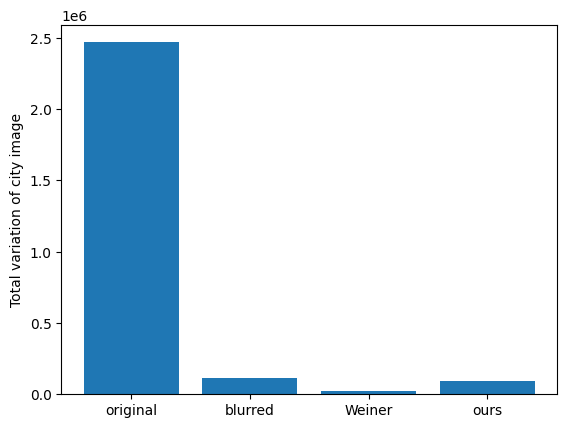

In [177]:
b1 = resize(color.rgb2gray(io.imread("D:/SEM 4/Project2/noisy.jpg")),(512,512))
im = resize(color.rgb2gray(io.imread("D:/SEM 4/Project2/clear.jpg")),(512,512))
plt.figure(1)
plt.title("ORIGINAL")
plt.imshow(im, cmap='gray')

# Blurred image

A = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(im)))
h = np.exp(-(x**2 + y**2)/10)
H = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(h)))
b = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(A*H))))

# Add noise
noise = np.random.rand(512,512) * 0.001 * np.mean(b[:])
b = b + noise
plt.figure(2)
plt.title("NOISY")
plt.imshow(b1, cmap='gray')

#Delta C
#Gin=guess
#Gout=blur
plt.figure(3)
plt.title('BLURRED')
plt.imshow(b, cmap='gray')

Gin= np.array(b1)
Gout=np.array(b)

def TV_np(a):
    ux, uy = np.gradient(a)
    g = np.sqrt(np.abs(ux)**2 + np.abs(uy)**2 + 1e-10)
    s = np.sum(g[:])
    return s
def gradd(Gin, Gout, alpha):
    #First term
    term1=-2*(Gout-Gin)
    
    #Second term
    delGin= np.gradient(Gin)
    gx=delGin[1]
    gy=delGin[0]
    denom = np.sqrt(gx**2 + gy**2 + np.random.rand(512,512))
    
    term2= alpha*(np.gradient(np.divide(gx,denom))[1]+ np.gradient(np.divide(gy,denom),1)[0])
    delC= term1 - term2
    return delC
def Cmin(Gout,Gin,alpha):
    C_Gin= np.linalg.norm((Gout-Gin))**2 + alpha*TV_np(Gin)
    return C_Gin

t = 0.1

alpha=1
Tvalpha=[]
alphar=[]
werr=[]
berr=[]
for i in range(12):
    if (i==1):
        break
    guess_np=b1
    for iter in np.arange(1,11,1):
        dC = gradd(guess_np, Gout, alpha)
        donet = 0
        C=Cmin(Gout,guess_np,alpha)
        while(not donet):
            guess_try = guess_np - t*dC
            Ctry=Cmin(Gout,guess_try,alpha)
           
            
            if(Ctry < C):
                donet = 1
                guess_np = guess_try
            else:
                t = t/2
                
        if(t < 1e-6):
            break
        else:
            t = 0.1 
    Tvalpha.append(TV(guess_np))
    alphar.append(alpha)
    berr.append(np.mean((guess_np-b)**2))
    werr.append(np.mean((guess_np-b1)**2))
    alpha=alpha*10
plt.figure(4)
plt.title("TV")
plt.imshow(guess_np, cmap='gray') 


print("TV of original image: ", TV(im))
print("TV of blurred image: ", TV(b))
print("TV of noisy image: ", TV(b1))
print("TV of our image: ", TV(guess_np))
plt.figure(5)
plt.bar(['original','blurred','Weiner', 'ours'],[TV(img),TV(b),TV(b1),TV(guess_np)])
plt.ylabel("Total variation of city image")
plt.show()

# FINAL IMAGES

(512, 512)

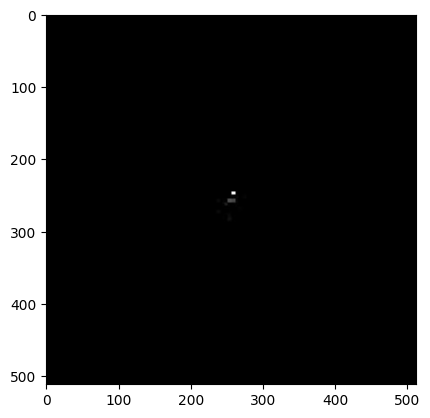

In [36]:
# Read a test image
from skimage import color
from skimage.transform import resize
img = io.imread("D:/SEM 3/PROJECT/finalimages/signal/jet_image_jet_constituents_data_0.jpeg")
plt.figure(1)

# plt.show()

org = resize(color.rgb2gray(img),(512,512))
plt.imshow(org, cmap='gray')
org.shape

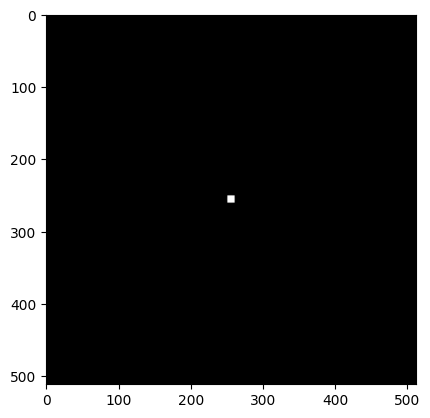

In [43]:
# Define a blur function on the grid
x0 = np.linspace(-255.5, 255.5, 512, endpoint=True)
x, y = np.meshgrid(x0,x0)
 # Square window psf
# h = np.sinc(x/5) * np.sinc(y/5)  # sinc blur function
h = np.exp(-(x**2 + y**2)/10) 
# Gaussian psf extending everywhere
h[(np.abs(x)<5) * (np.abs(y)<5)] = 1 

h = h / np.sum(h[:])
plt.figure(2)
plt.imshow(h, cmap='gray')


In [39]:
# # Blurred image

# A = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(org)))
# H = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(h)))
# b = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(A*H))))

# # Add noise
# noise = np.random.rand(512,512) * 0.001 * np.mean(b[:])
# b = b + noise

# plt.figure(3)
# plt.imshow(b, cmap='gray')
# plt.show()
# print(b)

(512, 512)


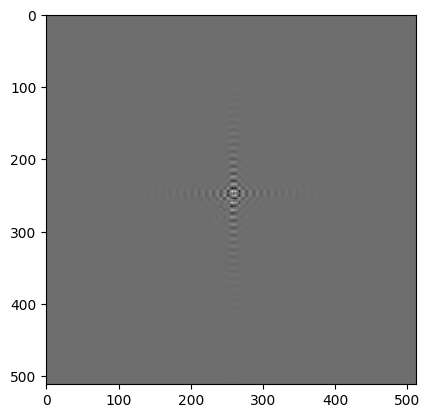

In [44]:
# Wiener filter recovery
NSR = 0.001
H = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(h)))
W = np.conj(H) / (np.abs(H)**2 + NSR)

# Deblur using Wiener filter
B = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(org)))
b1 = np.real(np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(B*W))))
print(b1.shape)
plt.figure(4)
plt.imshow(b1, cmap='gray')
plt.show()

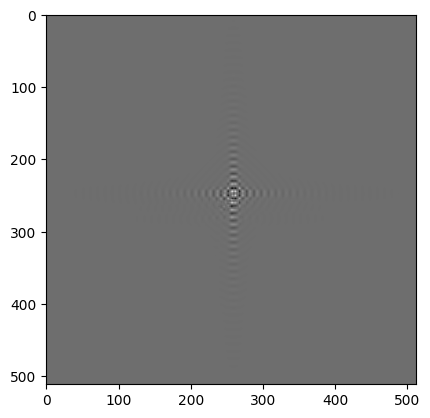

In [46]:
def TV(a):
    ux, uy = anp.gradient(a)
    g = anp.sqrt(anp.abs(ux)**2 + anp.abs(uy)**2 + 1e-10)
    s = anp.sum(g[:])
    return s

def data_error(guess, blurred, h):
    G = anp.fft.fftshift(anp.fft.fft2(anp.fft.ifftshift(guess)))
    H = anp.fft.fftshift(anp.fft.fft2(anp.fft.ifftshift(h)))
    err = blurred - anp.real(anp.fft.fftshift(anp.fft.ifft2(anp.fft.ifftshift(G*H))))
    err2 = err**2
    l2err = anp.sum(err2[:])
    return l2err   

# Iterative TV based deconvolution ... starting with Winer filter solution as first guess

gerr = grad(data_error, 0)
gtv = grad(TV, 0)

alpha = 10000000000
guess = b1
t = 0.1
b=org
for iter in np.arange(1,11,1):
    
    C1 = data_error(guess, b, h)
    dC1 = gerr(guess, b, h)
    C2 = TV(guess)
    dC2 = gtv(guess)
    C = C1 + alpha*C2
    dC = dC1 + alpha*dC2
    dC = dC / np.linalg.norm(dC)
    donet = 0
    
    while(not donet):
        guess_try = guess - t* np.linalg.norm(guess) * dC
        C1try = data_error(guess_try, b, h)
        C2try = TV(guess_try)
        Ctry = C1try + alpha*C2try
        
        if(Ctry < C):
            donet = 1
            guess = guess_try
        else:
            t = t/2
            
    if(t < 1e-6):
        break
    else:
        t = 0.1


plt.figure(5)
plt.imshow(guess, cmap='gray')
plt.show()


In [47]:
error1= (guess-b)**2
print("SSQ Error Autograd from blurred image: ", np.mean(error1))
error2= (guess-org)**2
print("SSQ Error Autograd from Original image: ", np.mean(error2))
error3= (guess-b1)**2
print("SSQ Error Autograd from Weiner image: ", np.mean(error3))


SSQ Error Autograd from blurred image:  0.005124372009895552
SSQ Error Autograd from Original image:  0.005124372009895552
SSQ Error Autograd from Weiner image:  5.229470498522079e-07


SSQ Error Autograd from blurred image:  4.115075466950357e-05
SSQ Error Autograd from Original image:  4.115075466950357e-05
SSQ Error Autograd from Weiner image:  0.005121937674014611


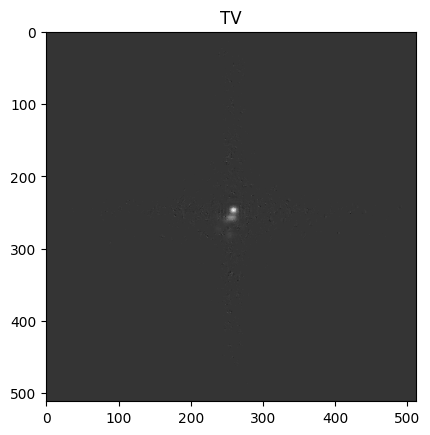

In [52]:
Gin= np.array(b1)
Gout=np.array(org)
def TV_np(a):
    ux, uy = np.gradient(a)
    g = np.sqrt(np.abs(ux)**2 + np.abs(uy)**2 + 1e-10)
    s = np.sum(g[:])
    return s
def gradd(Gin, Gout, alpha):
    #First term
    term1=-2*(Gout-Gin)
    
    #Second term
    delGin= np.gradient(Gin)
    gx=delGin[1]
    gy=delGin[0]
    denom = np.sqrt(gx**2 + gy**2 + np.random.rand(512,512))
    
    term2= alpha*(np.gradient(np.divide(gx,denom))[1]+ np.gradient(np.divide(gy,denom),1)[0])
    delC= term1 - term2
    return delC
def Cmin(Gout,Gin,alpha):
    C_Gin= np.linalg.norm((Gout-Gin))**2 + alpha*TV_np(Gin)
    return C_Gin

t = 0.1

alpha=10
Tvalpha=[]
alphar=[]
werr=[]
berr=[]
for i in range(12):
    if (i==1):
        break
    guess_np=b1
    for iter in np.arange(1,11,1):
        dC = gradd(guess_np, Gout, alpha)
        donet = 0
        C=Cmin(Gout,guess_np,alpha)
        while(not donet):
            guess_try = guess_np - t*dC
            Ctry=Cmin(Gout,guess_try,alpha)
           
            
            if(Ctry < C):
                donet = 1
                guess_np = guess_try
            else:
                t = t/2
                
        if(t < 1e-6):
            break
        else:
            t = 0.1 


plt.figure(4)
plt.title("TV")
plt.imshow(guess_np, cmap='gray') 
error1= (guess_np-b)**2
print("SSQ Error Autograd from blurred image: ", np.mean(error1))
error2= (guess_np-org)**2
print("SSQ Error Autograd from Original image: ", np.mean(error2))
error3= (guess_np-b1)**2
print("SSQ Error Autograd from Weiner image: ", np.mean(error3))
